In [18]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import pickle
from keras.models import Model
from kdg import kdcnn, kdf, kdn
import pickle
from tensorflow.keras.datasets import cifar10
import timeit
from joblib import dump, load
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as bknd
from tqdm import tqdm
import seaborn as sns

In [6]:
def sim_circle(center, r=10, rgb=None):
    img_size = [100,100,3]
    if rgb is None:
        rgb = 255*np.random.uniform(size=3)
        
    img = 0*np.ones(img_size,dtype=int)

    for x in range(img_size[0]):
        for y in range(img_size[1]):
            dis = np.sqrt((x - center[0])**2 + (y - center[1])**2)
            if dis < r:
                img[x,y,0] = rgb[0]
                img[x,y,1] = rgb[1]
                img[x,y,2] = rgb[2]

    return img

def sim_rectangle(center, w=10, h=5, rgb=None):
    img_size = [100,100,3]
    if rgb is None:
        rgb = 255*np.random.uniform(size=3)
        
    img = 0*np.ones(img_size,dtype=int)

    for x in range(img_size[0]):
        for y in range(img_size[1]):
            if np.abs(center[0]-x) < h//2 and np.abs(center[1]-y) < w//2:
                img[x,y,0] = rgb[0]
                img[x,y,1] = rgb[1]
                img[x,y,2] = rgb[2]
    
    return img

def sim_ellipse(center, a=10, b=30, rgb=None):
    img_size = [100,100,3]
    if rgb is None:
        rgb = 255*np.random.uniform(size=3)
        
    img = 0*np.ones(img_size,dtype=int)

    for x in range(img_size[0]):
        for y in range(img_size[1]):
            dis = (x - center[0])**2/a**2 + (y - center[1])**2/b**2
            if dis < 1:
                img[x,y,0] = rgb[0]
                img[x,y,1] = rgb[1]
                img[x,y,2] = rgb[2]
    
    return img

In [7]:
img = sim_circle([60,60], r=10, rgb=[127,127,127])
img_rect = sim_rectangle([30,40], w=50, h=20, rgb=[127,127,127])
img_ell = sim_ellipse([60,60], a=10, b=30, rgb=[127,127,127])

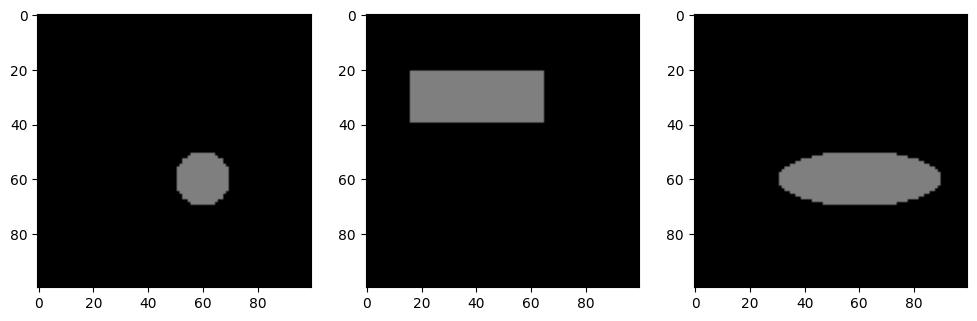

In [8]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img)
ax[1].imshow(img_rect)
ax[2].imshow(img_ell)

In [11]:
def get_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(3, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(10, name='dense_'))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(units=2, activation="softmax"))

    model.compile(**compile_kwargs)
    return model

In [6]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 100,
        "batch_size": 32,
        "verbose": False,
        "callbacks": [callback],
    }

In [7]:
#Generate training data
def generate_training_data(sample_circle = 1000, sample_rectangle = 1000, rgb=[127,127,127]):
    X = []
    X_ood = []
    y = []
    
    
    for ii in range(sample_circle):
        center = 100*np.random.uniform(size=2)
        X.append(
            sim_circle(center, r=10, rgb=rgb)
        )
        y.append(0)
    
    for ii in range(sample_rectangle):
        center = 100*np.random.uniform(size=2)
        X.append(
            sim_rectangle(center, w=50, h=20, rgb=rgb)
        )
        y.append(1)
    
    
    X = np.array(X)

    return X, y

def get_ood_ellipse(a, b, sample_ellipse = 100, rgb=[127,127,127]):
    X_ood = []
    for ii in range(sample_ellipse):
        center = 100*np.random.uniform(size=2)
        X_ood.append(
            sim_ellipse(center, a=a, b=b, rgb=rgb)
        )
    
    X_ood = np.array(X_ood)
    return X_ood

In [299]:
X, y = generate_training_data()

In [300]:
cnn = get_cnn()
print(cnn.summary())
history = cnn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 98, 98, 3)         84        
                                                                 
 flatten (Flatten)           (None, 28812)             0         
                                                                 
 activation_157 (Activation)  (None, 28812)            0         
                                                                 
 dense (Dense)               (None, 10)                288130    
                                                                 
 activation_158 (Activation)  (None, 10)               0         
                                                                 
 dense_80 (Dense)            (None, 2)                 22        
                                                                 
Total params: 288,236
Trainable params: 288,236
Non-t

2024-03-03 23:55:49.543563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

In [310]:
model_kdn = kdcnn(
        network=cnn,
        output_layer='dense'
    )
model_kdn.fit(X, y, k=12, batch=10)
    

45/63 [====================>.........] - ETA: 0s

2024-03-04 00:01:11.381722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]


Fitting data!


In [356]:
model_kdn.global_bias = -65

In [373]:
eps = 0.5
X_, _ = generate_training_data(sample_circle=200, sample_rectangle=200)
X_ood = eps*X_[:200] + (1-eps)*X_[200:]

In [374]:
np.mean(np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'),axis=1))

7/7 [==============================] - 0s 6ms/step


2024-03-04 00:09:24.276506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s]


0.6932993916598253

In [ ]:
def experiment_delta(reps=10):
    res = []
    res_dn = []

    for ii in range(reps):
        print("Doing reps ", ii)
        
        tmp = []
        tmp_dn = []
        X, y = generate_training_data()
        cnn = get_cnn()
        history = cnn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
        model_kdn = kdcnn(
                        network=cnn,
                        output_layer='dense'
                        )
        model_kdn.fit(X, y, k=12, batch=10)
        model_kdn.global_bias = -58
    
        for a in range(127,-127,-5):
            X_ood, _ = generate_training_data(sample_circle=20, sample_rectangle=20, rgb=[127+a,127+a,127+a])
            proba = model_kdn.predict_proba(X_ood, distance='Geodesic')
            proba_dn = model_kdn.network.predict(X_ood)
            mean_max_proba = np.mean(np.max(proba, axis=1))
            mean_max_proba_dn = np.mean(np.max(proba_dn, axis=1))
            tmp.append(mean_max_proba)
            tmp_dn.append(mean_max_proba_dn)
        res.append(tmp)
        res_dn.append(tmp_dn)

    return res, res_dn
        

##### res_delta, res_delta_dn = experiment_delta()

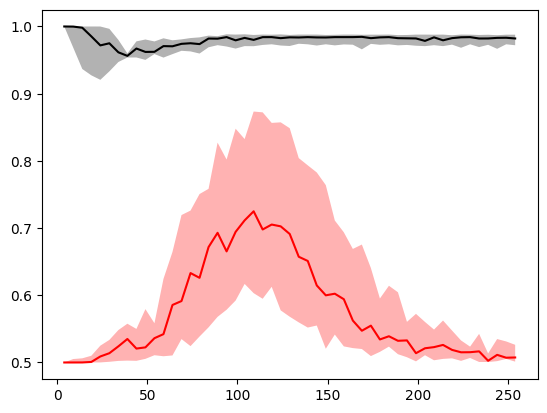

In [117]:
plt.plot(np.array(range(127,-127,-5))+127, np.median(np.array(res_delta),axis=0), color='r')
plt.fill_between(np.array(range(127,-127,-5))+127, np.quantile(np.array(res_delta), [0.25], axis=0)[0], np.quantile(np.array(res_delta), [0.75], axis=0)[0], facecolor='r', alpha=.3)


plt.plot(np.array(range(127,-127,-5))+127, np.median(np.array(res_delta_dn),axis=0), color='k')
plt.fill_between(np.array(range(127,-127,-5))+127, np.quantile(np.array(res_delta_dn), [0.25], axis=0)[0], np.quantile(np.array(res_delta_dn), [0.75], axis=0)[0], facecolor='k', alpha=.3)

In [375]:
def experiment_eps(reps=20):
    res = []
    res_dn = []

    for ii in range(reps):
        print("Doing reps ", ii)
        
        tmp = []
        tmp_dn = []
        X, y = generate_training_data()
        cnn = get_cnn()
        history = cnn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
        model_kdn = kdcnn(
                        network=cnn,
                        output_layer='dense'
                        )
        model_kdn.fit(X, y, k=12, batch=10)
        model_kdn.global_bias = -65
    
        for eps in np.arange(0,1.05,.05):
            X_, _ = generate_training_data(sample_circle=200, sample_rectangle=200)
            X_ood = eps*X_[:200] + (1-eps)*X_[200:]
            proba = model_kdn.predict_proba(X_ood, distance='Geodesic')
            proba_dn = model_kdn.network.predict(X_ood)
            mean_max_proba = np.mean(np.max(proba, axis=1))
            mean_max_proba_dn = np.mean(np.max(proba_dn, axis=1))
            tmp.append(mean_max_proba)
            tmp_dn.append(mean_max_proba_dn)
        res.append(tmp)
        res_dn.append(tmp_dn)

    return res, res_dn
    

In [376]:
res_eps, res_eps_dn = experiment_eps()

Doing reps  0


2024-03-04 00:12:41.199461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

42/63 [===================>..........] - ETA: 0s

2024-03-04 00:13:37.604923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.18it/s]


Fitting data!
7/7 [==============================] - 0s 14ms/step


2024-03-04 00:13:42.713630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s]
2024-03-04 00:13:43.206192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:13:47.629226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.13it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:13:52.401195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:13:57.118198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:14:01.805567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:14:06.554745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:14:11.315709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.49it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:14:16.051519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.57it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 18ms/step


2024-03-04 00:14:20.870555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.25it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 20ms/step


2024-03-04 00:14:25.904485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 16ms/step


2024-03-04 00:14:30.927582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.05it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:14:35.856615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.49it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:14:40.604926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:14:45.337386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:14:50.069177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:14:54.895300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:14:59.687425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.95it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:15:04.415680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.07it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:15:09.100432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:15:13.905317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:15:18.579316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  1


2024-03-04 00:15:40.279812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

52/63 [=======================>......] - ETA: 0s

2024-03-04 00:16:37.947380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.31it/s]


Fitting data!
7/7 [==============================] - 0s 13ms/step


2024-03-04 00:16:43.160038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s]
2024-03-04 00:16:43.581001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:16:48.073719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:16:52.931226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:16:57.678320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 18ms/step


2024-03-04 00:17:02.532864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.52it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:17:07.343260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:17:12.161263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:17:17.026164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:17:21.736165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.98it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:17:26.457407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:17:31.134051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.00it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:17:35.885816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:17:40.640480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:17:45.378383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:17:50.088134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:17:54.805463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:17:59.538853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:18:04.207744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:18:08.927465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.75it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:18:13.676203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.98it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:18:18.457261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  2


2024-03-04 00:18:40.230183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

36/63 [================>.............] - ETA: 0s

2024-03-04 00:19:37.720630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 4ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]


Fitting data!
7/7 [==============================] - 0s 15ms/step


2024-03-04 00:19:43.057063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.79it/s]
2024-03-04 00:19:43.515249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:19:48.010815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:19:52.741851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.63it/s]

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 18ms/step


2024-03-04 00:19:57.574062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.41it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:02.493627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.95it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:07.293642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:11.979095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:16.675428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:20:21.341226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:25.977023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:30.683940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.09it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:35.350819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:20:40.038631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:20:44.745139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:20:49.393823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:20:54.100819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:20:58.751845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:21:03.579924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.57it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:21:08.413427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:21:13.135359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.03it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:21:17.787256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  3


2024-03-04 00:21:39.821823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

48/63 [=====================>........] - ETA: 0s

2024-03-04 00:22:36.751987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.72it/s]


Fitting data!
7/7 [==============================] - 0s 14ms/step


2024-03-04 00:22:41.896486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]
2024-03-04 00:22:42.380476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:22:46.863174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:22:51.693594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:22:56.433019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:23:01.153138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.32it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:23:05.967341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:23:10.785064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:23:15.489266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.72it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:23:20.199483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:23:24.834284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:23:29.438200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:23:34.168086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:23:38.901679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.13it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:23:43.582541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:23:48.253825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:23:52.951847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.04it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:23:57.659315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:24:02.291668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:24:06.980814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:24:11.632375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:24:16.339749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  4


2024-03-04 00:24:38.256823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

62/63 [============================>.] - ETA: 0s

2024-03-04 00:25:34.518459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 4ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]


Fitting data!
7/7 [==============================] - 0s 8ms/step


2024-03-04 00:25:39.771553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s]

1/7 [===>..........................] - ETA: 0s


2024-03-04 00:25:40.162848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:25:44.612442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 6ms/step


2024-03-04 00:25:49.250533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:25:53.903620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:25:58.538216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:26:03.133399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:26:07.728684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:26:12.386809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.06it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:26:17.111141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.88it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:26:21.802732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.84it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:26:26.636998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 15ms/step


2024-03-04 00:26:31.503585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:26:36.180164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:26:40.832731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 6ms/step


2024-03-04 00:26:45.496972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:26:50.121666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:26:54.841678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:26:59.476686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:27:04.122431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:27:08.736541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:27:13.430395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  5


2024-03-04 00:27:34.960162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

52/63 [=======================>......] - ETA: 0s

2024-03-04 00:28:31.003851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 2ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.67it/s]


Fitting data!
7/7 [==============================] - 0s 14ms/step


2024-03-04 00:28:36.133946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]
2024-03-04 00:28:36.602074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:28:41.109778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.47it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:28:45.852747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.63it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:28:50.724404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.63it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:28:55.442756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:29:00.167536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:29:04.964932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:29:09.730189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:29:14.423403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:29:19.213759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:29:24.029025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:29:28.727006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:29:33.326023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:29:38.015895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:29:42.683639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:29:47.299219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:29:51.922434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:29:56.490052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:30:01.124753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:30:05.845211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:30:10.560465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  6


2024-03-04 00:30:32.488806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

45/63 [====================>.........] - ETA: 0s

2024-03-04 00:31:29.426151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


Fitting data!
7/7 [==============================] - 0s 15ms/step


2024-03-04 00:31:34.688500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]
2024-03-04 00:31:35.132409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:31:39.702092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.56it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:31:44.449228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.06it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:31:49.185962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:31:53.938338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.18it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:31:58.688878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:32:03.475693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.16it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:32:08.218033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.10it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:32:12.931862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:32:17.654799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:32:22.425852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.83it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:32:27.211618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.70it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:32:31.987671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:32:36.744316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.00it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:32:41.462205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:32:46.163581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:32:50.934207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:32:55.677232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.04it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:33:00.456610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.10it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:33:05.196280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.04it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:33:09.944103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  7


2024-03-04 00:33:31.755842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

52/63 [=======================>......] - ETA: 0s

2024-03-04 00:34:29.435893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.55it/s]


Fitting data!
7/7 [==============================] - 0s 14ms/step


2024-03-04 00:34:34.602197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s]
2024-03-04 00:34:35.040809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:34:39.452068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:34:44.140659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:34:48.927084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.95it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:34:53.642026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.19it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:34:58.451445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:35:03.139039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:35:07.811963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:35:12.548259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:35:17.245923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:35:21.906842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:35:26.586250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.70it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:35:31.369917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:35:36.011497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:35:40.720140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:35:45.499181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.87it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:35:50.317975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:35:55.151300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.51it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:35:59.971024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.80it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:36:04.774737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.00it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:36:09.550141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.72it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  8


2024-03-04 00:36:31.280511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

42/63 [===================>..........] - ETA: 0s

2024-03-04 00:37:33.328062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.42it/s]


Fitting data!
7/7 [==============================] - 0s 11ms/step


2024-03-04 00:37:38.544001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.80it/s]
2024-03-04 00:37:38.982437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:37:43.456524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.62it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:37:48.167529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.94it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:37:52.937233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.04it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:37:57.670383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:38:02.386435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.00it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:38:07.163886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.98it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:38:11.932175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.05it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:38:16.710464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:38:21.491619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:38:26.265533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:38:30.943314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:38:35.553388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:38:40.168553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:38:44.814020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.74it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:38:49.646929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.31it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:38:54.416574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:38:59.141317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:39:03.872513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 11ms/step


2024-03-04 00:39:08.571248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:39:13.308750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  9


2024-03-04 00:39:35.076235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

51/63 [=======================>......] - ETA: 0s

2024-03-04 00:40:38.390887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.51it/s]


Fitting data!
7/7 [==============================] - 0s 15ms/step


2024-03-04 00:40:43.508356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s]
2024-03-04 00:40:43.937060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:40:48.389202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:40:53.041819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:40:57.711511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:41:02.332911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.18it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:41:07.011879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:41:11.702716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:41:16.330271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:41:20.958253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:41:25.591925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:41:30.210073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:41:34.848588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:41:39.498595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:41:44.181332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:41:48.819069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:41:53.497067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:41:58.116000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:42:02.783071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 18ms/step


2024-03-04 00:42:07.583730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.53it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:42:12.343496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.09it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:42:17.020760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.92it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  10


2024-03-04 00:42:38.282986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

43/63 [===================>..........] - ETA: 0s

2024-03-04 00:43:33.331290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.58it/s]


Fitting data!
7/7 [==============================] - 0s 14ms/step


2024-03-04 00:43:38.447123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s]
2024-03-04 00:43:38.879026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:43:43.306659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:43:47.976994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.10it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:43:52.626536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:43:57.300312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:44:02.016426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:44:06.691616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:44:11.399485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.98it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:44:16.099136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.07it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:44:20.824562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.18it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:44:25.560330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 00:44:30.258528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:44:34.951891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.03it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:44:39.585255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:44:44.252323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:44:48.933956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:44:53.614451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:44:58.352218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.05it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:45:03.047483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:45:07.701430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.94it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:45:12.384979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s]

7/7 [==============================] - 0s 4ms/step


Doing reps  11


2024-03-04 00:45:33.813832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

46/63 [====================>.........] - ETA: 0s

2024-03-04 00:46:29.166369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.37it/s]


Fitting data!
7/7 [==============================] - 0s 8ms/step


2024-03-04 00:46:34.325267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.18it/s]

1/7 [===>..........................] - ETA: 0s


2024-03-04 00:46:34.684145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:46:39.056391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:46:43.763008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.10it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:46:48.431719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.07it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:46:53.089615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.13it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:46:57.722561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:47:02.417999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:47:07.020948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.99it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 6ms/step


2024-03-04 00:47:11.693830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.06it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 00:47:16.327695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.09it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:47:20.953627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.06it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:47:25.608865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.10it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:47:30.299911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:47:35.010729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:47:39.736530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:47:44.480919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:47:49.174163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:47:53.836566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.03it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:47:58.514497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:48:03.221514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:48:07.882305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  12


2024-03-04 00:48:29.449039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

44/63 [===================>..........] - ETA: 0s

2024-03-04 00:49:24.236865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.34it/s]


Fitting data!
7/7 [==============================] - 0s 15ms/step


2024-03-04 00:49:29.380271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.92it/s]
2024-03-04 00:49:29.845648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:49:34.258383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:49:38.977521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:49:43.660557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:49:48.330579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.79it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:49:53.059085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.03it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:49:57.742115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.71it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:02.398758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.76it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:07.077368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:11.783328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:16.481733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.95it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:50:21.185368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:50:25.882851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.00it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:30.547527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.75it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:50:35.254262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.79it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:50:39.969281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.88it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:44.690699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:50:49.396619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.10it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:54.074343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.03it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:50:58.751259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:51:03.454255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  13


2024-03-04 00:51:24.915396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

40/63 [==================>...........] - ETA: 0s

2024-03-04 00:52:20.448132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 4ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


Fitting data!
7/7 [==============================] - 0s 17ms/step


2024-03-04 00:52:25.621620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]
2024-03-04 00:52:26.081563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:52:30.500338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.83it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:52:35.191930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:52:39.864564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.99it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:52:44.557261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.87it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:52:49.243775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 00:52:53.905080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:52:58.620961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.83it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 00:53:03.271831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.83it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:53:07.976826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.94it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:53:12.664025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:53:17.363052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.88it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:53:22.077272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:53:26.740488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:53:31.445068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.83it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:53:36.118318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:53:40.807850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:53:45.520139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.80it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:53:50.198515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.82it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:53:54.911063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.87it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:53:59.615313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.82it/s]

7/7 [==============================] - 0s 5ms/step


Doing reps  14


2024-03-04 00:54:21.126701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

44/63 [===================>..........] - ETA: 0s

2024-03-04 00:55:16.417331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.37it/s]


Fitting data!
7/7 [==============================] - 0s 14ms/step


2024-03-04 00:55:21.567961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]
2024-03-04 00:55:22.016299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:55:26.458694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.98it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:55:31.178487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.84it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:55:35.862559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.01it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:55:40.551042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:55:45.266368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.79it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:55:49.928880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:55:54.609266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.80it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:55:59.307640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.76it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:56:03.998423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:56:08.670822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.72it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:56:13.362825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.09it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:56:18.019660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:56:22.679886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.82it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:56:27.400338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.82it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:56:32.074945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.65it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:56:36.762848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.80it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:56:41.462199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:56:46.117698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.74it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:56:50.828872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.32it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 00:56:55.660594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.50it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  15


2024-03-04 00:57:17.518339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

47/63 [=====================>........] - ETA: 0s

2024-03-04 00:58:13.250706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]


Fitting data!
7/7 [==============================] - 0s 15ms/step


2024-03-04 00:58:18.363524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.95it/s]
2024-03-04 00:58:18.769000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 12ms/step


2024-03-04 00:58:23.112662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.88it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:58:27.744099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 00:58:32.400982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.99it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:58:37.063096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:58:41.694038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:58:46.265500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:58:50.882027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:58:55.521011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.95it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 00:59:00.132605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.06it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:59:04.761830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.92it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 10ms/step


2024-03-04 00:59:09.416577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:59:14.017596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.98it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:59:18.690524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.04it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:59:23.288852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.94it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:59:27.888478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:59:32.566583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.00it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:59:37.171418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 00:59:41.873603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.06it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 00:59:46.476510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 00:59:51.142396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  16


2024-03-04 01:00:12.641431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

45/63 [====================>.........] - ETA: 0s

2024-03-04 01:01:08.324812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.54it/s]


Fitting data!
7/7 [==============================] - 0s 9ms/step


2024-03-04 01:01:13.399759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.07it/s]
2024-03-04 01:01:13.823395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 8ms/step


2024-03-04 01:01:18.233234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:01:22.903032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 01:01:27.513989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.92it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:01:32.203954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.98it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:01:36.805813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:01:41.418235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 7ms/step


2024-03-04 01:01:46.074421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.87it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 01:01:50.690187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.05it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:01:55.327029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.04it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 01:02:00.041610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:02:04.694469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.99it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:02:09.380305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:02:14.083424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:02:18.748424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:02:23.432856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:02:28.129339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.84it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:02:32.863740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.13it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:02:37.551860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.80it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:02:42.266782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 01:02:46.943888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.81it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  17


2024-03-04 01:03:08.612819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

40/63 [==================>...........] - ETA: 0s

2024-03-04 01:04:04.235441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.48it/s]


Fitting data!
7/7 [==============================] - 0s 13ms/step


2024-03-04 01:04:09.442200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]
2024-03-04 01:04:09.886549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 13ms/step


2024-03-04 01:04:14.310863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:04:19.019776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.94it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:04:23.683201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:04:28.367737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:04:33.025868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:04:37.704908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 01:04:42.381883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.79it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:04:47.060236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:04:51.785189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:04:56.490750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:05:01.220016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:05:05.938866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.71it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:05:10.593471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.70it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:05:15.290710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:05:20.012457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:05:24.721890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.79it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:05:29.423245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.60it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:05:34.115628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:05:38.808729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:05:43.472197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.87it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  18


2024-03-04 01:06:04.979711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

44/63 [===================>..........] - ETA: 0s

2024-03-04 01:07:00.450582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]


Fitting data!
7/7 [==============================] - 0s 16ms/step


2024-03-04 01:07:05.580852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]
2024-03-04 01:07:06.007038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:07:10.385973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.63it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 01:07:15.053975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.59it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:07:19.722077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:07:24.312049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.72it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 01:07:28.996911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.61it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:07:33.616785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.65it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:07:38.270163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.75it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 01:07:42.868745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.65it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 13ms/step


2024-03-04 01:07:47.471134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.71it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 9ms/step


2024-03-04 01:07:52.185397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:07:56.872464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 8ms/step


2024-03-04 01:08:01.525525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.60it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:08:06.200266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:08:10.874696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.80it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:08:15.614024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.60it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:08:20.363064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.69it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:08:25.052917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 01:08:29.747230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.61it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 01:08:34.514686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.35it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:08:39.391563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.57it/s]

7/7 [==============================] - 0s 3ms/step


Doing reps  19


2024-03-04 01:09:01.540044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

44/63 [===================>..........] - ETA: 0s

2024-03-04 01:10:04.367380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.29it/s]


Fitting data!
7/7 [==============================] - 0s 15ms/step


2024-03-04 01:10:09.617177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.08it/s]
2024-03-04 01:10:10.067951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:10:14.592960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:10:19.386037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.90it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:10:24.145470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:10:28.925808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:10:33.713655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.83it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:10:38.445397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.93it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:10:43.176956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.97it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:10:47.931354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.03it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:10:52.712622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:10:57.482523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 01:11:02.225367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.91it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:11:06.982983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.75it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:11:11.737914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:11:16.476562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.75it/s]

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:11:21.238893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.92it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:11:26.015549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 15ms/step


2024-03-04 01:11:30.754535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 14ms/step


2024-03-04 01:11:35.495343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.96it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 17ms/step


2024-03-04 01:11:40.256056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.62it/s]

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 16ms/step


2024-03-04 01:11:45.008224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]

7/7 [==============================] - 0s 3ms/step


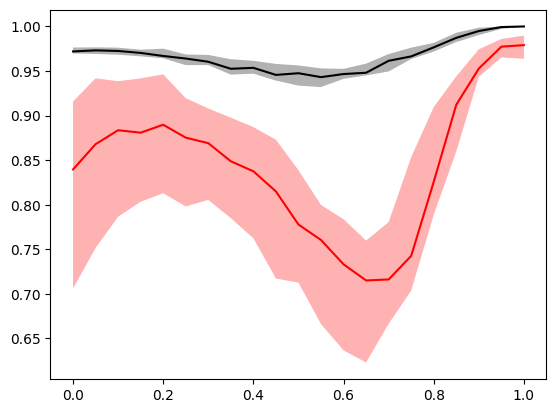

In [377]:
plt.plot(np.arange(0,1.05,.05), np.median(np.array(res_eps),axis=0), color='r')
plt.fill_between(np.arange(0,1.05,.05), np.quantile(np.array(res_eps), [0.25], axis=0)[0], np.quantile(np.array(res_eps), [0.75], axis=0)[0], facecolor='r', alpha=.3)

plt.plot(np.arange(0,1.05,.05), np.median(np.array(res_eps_dn),axis=0), color='k')
plt.fill_between(np.arange(0,1.05,.05), np.quantile(np.array(res_eps_dn), [0.25], axis=0)[0], np.quantile(np.array(res_eps_dn), [0.75], axis=0)[0], facecolor='k', alpha=.3)


In [12]:
def experiment_size(reps=10):
    res = []
    res_dn = []

    for ii in range(reps):
        print("Doing reps ", ii)
        
        tmp = []
        tmp_dn = []
        X, y = generate_training_data()
        cnn = get_cnn()
        history = cnn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
        model_kdn = kdcnn(
                        network=cnn,
                        output_layer='dense_'
                        )
        model_kdn.fit(X, y, k=1.2, batch=10)
        model_kdn.global_bias = -60
    
        for eps in np.arange(-9.99,30,.5):
            X_ood = get_ood_ellipse(a=10,b=10+eps, sample_ellipse=40)
            proba = model_kdn.predict_proba(X_ood, distance='Geodesic')
            proba_dn = model_kdn.network.predict(X_ood)
            mean_max_proba = np.mean(np.max(proba, axis=1))
            mean_max_proba_dn = np.mean(np.max(proba_dn, axis=1))
            tmp.append(mean_max_proba)
            tmp_dn.append(mean_max_proba_dn)
        res.append(tmp)
        res_dn.append(tmp_dn)

    return res, res_dn

In [13]:
res_size, res_size_dn = experiment_size()

Doing reps  0


2024-03-04 01:34:36.143691: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-04 01:34:36.268587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

63/63 [==============================] - 0s 2ms/step


2024-03-04 01:35:28.282679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]


Fitting data!
2/2 [==============================] - 0s 30ms/step


2024-03-04 01:35:29.690657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.79it/s]
2024-03-04 01:35:29.961576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:30.442342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.86it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:35:31.113163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:31.773113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.06it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:35:32.423233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:35:33.083384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.59it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:33.746451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:34.397314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.89it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:35.052596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.94it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:35.702158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:36.356111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.86it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:37.006731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.96it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:37.655841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.88it/s]


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:38.307130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.92it/s]


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:35:38.956288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:39.603885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.53it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:40.256013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.94it/s]


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:40.907814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.95it/s]


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:41.565043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:42.229122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:42.884901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.89it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:43.533096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.86it/s]


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:44.188346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:44.840382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:45.492406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:46.153260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:46.812169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.63it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:47.465492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.89it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:48.118431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:48.774610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:49.428919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.51it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:50.090675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.86it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:50.742253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.60it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:51.401016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.61it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:52.061406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:52.730495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:53.386772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:54.054872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.71it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:54.713327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.56it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:55.380874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:56.048246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.87it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:56.705782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:35:57.364965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:58.020335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2024-03-04 01:35:58.685880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:35:59.346198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:00.009770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.78it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:00.679902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:36:01.344034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.81it/s]


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:02.009093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.65it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:02.676268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:03.354162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.53it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:04.039240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:04.714161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:36:05.386239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:36:06.079743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:06.756406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:36:07.429815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:36:08.099006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:36:08.770607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:36:09.469661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:36:10.174054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:36:10.869691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:36:11.568785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:12.269623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:12.970248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:36:13.679108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:14.368354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:15.069942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.14it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:36:15.755311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.58it/s]


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:36:16.454015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:36:17.152842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.25it/s]


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:36:17.858334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:18.542580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:19.218394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.56it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:19.897185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.55it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:20.578258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:36:21.251481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.54it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:21.933754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.46it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:36:22.612622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.60it/s]

2/2 [==============================] - 0s 3ms/step
Doing reps  1



2024-03-04 01:36:43.996402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
lo

63/63 [==============================] - 0s 2ms/step


2024-03-04 01:37:35.272902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.84it/s]


Fitting data!
2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:36.430828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]
2024-03-04 01:37:36.679101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:37:37.162575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.52it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:37:37.821460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:37:38.478848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:37:39.141123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:37:39.805959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:40.460619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:41.116864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:37:41.780643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:37:42.439630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:37:43.097074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.59it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:37:43.754104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.68it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:44.413395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:37:45.076129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.80it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:45.752590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.64it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:46.420661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:47.080137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.65it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:47.740762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.57it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:37:48.405602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.60it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:37:49.076064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.53it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:49.756011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.54it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:50.426557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.57it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:51.103299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:37:51.771233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.60it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:52.440370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.54it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:37:53.105113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:37:53.776383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.56it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:54.442310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:37:55.115956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.52it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:55.781984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.52it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:56.447866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.58it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:57.114667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:57.789187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.55it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:37:58.453437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.55it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:37:59.128505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.48it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:37:59.805922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:00.486154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:01.154090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:01.824808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.44it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:02.496798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:03.167867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:03.845213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.54it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:38:04.526174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.49it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:05.198336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.52it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:38:05.883435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.51it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:06.561347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:07.230716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:38:07.898282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.36it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:08.582255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.55it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:09.252647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.20it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:09.950045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.50it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:10.628328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:11.308041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:11.993677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:12.674044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:13.352941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:38:14.033952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:14.714017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:15.386170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.46it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:16.061621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:16.742266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.49it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:38:17.415900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:38:18.086670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.48it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:38:18.762328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:19.440549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.41it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:38:20.125843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:20.807220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:21.487200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:22.176467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.53it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:22.851625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.29it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:23.534257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:38:24.223787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:24.908218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:25.587591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.38it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:38:26.272892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:26.954662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:38:27.625688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:38:28.311253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:38:29.002539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:38:29.688637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.29it/s]

2/2 [==============================] - 0s 3ms/step


Doing reps  2


2024-03-04 01:38:50.997316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 2ms/step


2024-03-04 01:39:42.555715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.99it/s]


Fitting data!
2/2 [==============================] - 0s 17ms/step


2024-03-04 01:39:43.705932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.57it/s]
2024-03-04 01:39:43.959530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:39:44.436344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.36it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:45.115202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.28it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:45.789072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.22it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:39:46.457573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.62it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:47.138998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:47.824585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:39:48.499292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:39:49.160434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.59it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:49.838376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.14it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:50.512864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:39:51.200246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:51.870762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.21it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:39:52.540568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.32it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:39:53.210364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:39:53.893790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.28it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:54.569921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:39:55.247943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.39it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:55.932163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.20it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:39:56.600867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.28it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:39:57.281412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:57.958707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:58.633059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:59.310397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:39:59.991316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:00.680081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.26it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:40:01.349983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:02.033260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:02.714902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:03.387120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:04.063295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:04.736193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:40:05.417871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:06.104517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:40:06.791422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:40:07.470903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:08.153432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:08.841279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:09.518634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:40:10.205887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.01it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:10.890799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:11.570829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:12.247736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:12.920067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.21it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:13.598654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.20it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:14.284077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:40:14.963017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.27it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:40:15.646038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.43it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:16.326234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:40:17.009114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:40:17.696110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:18.381551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:19.062652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:19.750768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:20.434240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:40:21.119734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:21.793524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.15it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:40:22.474561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:23.161828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.17it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:40:23.833090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.14it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:24.515310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:25.201081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:25.889490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:26.578360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:40:27.265925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:27.942201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:28.632770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:40:29.314229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.21it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:40:30.009183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:40:30.703811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.23it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:40:31.400914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:32.097789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.14it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:32.784086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.22it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:33.465182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:40:34.160830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:40:34.847202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.10it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:40:35.538989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.20it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:40:36.237224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:40:36.931620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:40:37.630919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]

2/2 [==============================] - 0s 3ms/step


Doing reps  3


2024-03-04 01:40:59.084345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 2ms/step


2024-03-04 01:41:50.731029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.65it/s]


Fitting data!
2/2 [==============================] - 0s 24ms/step


2024-03-04 01:41:51.895395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.31it/s]
2024-03-04 01:41:52.156453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:41:52.654471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:41:53.325718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:41:53.999129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:41:54.668384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:41:55.352422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:41:56.043479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:41:56.713591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.06it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:41:57.388980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:41:58.064489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:41:58.732637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:41:59.407142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:00.086243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:00.762104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:01.442190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:02.134547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:02.809695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:03.488059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:04.161882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:42:04.842068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:42:05.518741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:42:06.197802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:06.889036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:07.585535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:42:08.269284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:42:08.951252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:42:09.643110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:42:10.338049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:11.029972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:11.707619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:12.385156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:13.071479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:13.754315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:14.435985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:15.122406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:15.809423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:42:16.496353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:17.186436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:17.881506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:18.575464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:19.275470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:19.964129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:20.653504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:21.361067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:22.043009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:22.733468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:42:23.430704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.48it/s]


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:24.133582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:42:24.839094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:25.526134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:42:26.217709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:42:26.909314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.01it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:42:27.597652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:28.288858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.51it/s]


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:28.976367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:42:29.669072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:42:30.370717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:31.070859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:42:31.766355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 24ms/step


2024-03-04 01:42:32.450123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:33.149480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 14ms/step


2024-03-04 01:42:33.838610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:42:34.517654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:35.216581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:42:35.906759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:36.608983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:37.306629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:42:38.001635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:42:38.702736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:39.405631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:40.096064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 24ms/step


2024-03-04 01:42:40.796308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:41.491035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:42.186885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:42.882084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:43.576365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:44.260561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:42:44.954929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:42:45.658016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 14ms/step


2024-03-04 01:42:46.344574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.39it/s]


2/2 [==============================] - 0s 3ms/step
Doing reps  4


2024-03-04 01:43:07.690382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 2ms/step


2024-03-04 01:43:59.136425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s]


Fitting data!
2/2 [==============================] - 0s 15ms/step


2024-03-04 01:44:00.323868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]
2024-03-04 01:44:00.582121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:44:01.067671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:44:01.742910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:44:02.422394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:03.097829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:03.791599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:44:04.473331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:05.161026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:05.849248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:44:06.523382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:44:07.215828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:07.895522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:44:08.572552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:44:09.249141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:44:09.930397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:10.621039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:44:11.310826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:12.001551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:44:12.700983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:44:13.389189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:14.089002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:44:14.769604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:15.466319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:16.155725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:16.848290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:44:17.546388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 24ms/step


2024-03-04 01:44:18.243287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:18.939039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:19.628671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:20.300754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:20.978330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:44:21.674432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:22.373954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:23.058911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:44:23.749390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:24.437059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:25.119473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:25.815749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:26.513757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:27.215009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:27.912945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:28.597073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:29.289114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:29.978727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:44:30.670317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:31.366491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:44:32.054584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:32.764300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:33.456501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:34.147424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:34.842132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:44:35.529238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:36.228361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:36.929102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:37.626770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:38.323518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:44:39.024042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:39.716310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:44:40.409622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:41.113100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:41.822232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:42.529961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:44:43.225721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:43.915862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:44.624228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:44:45.317933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:44:46.019190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:46.719788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:47.413281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:44:48.102906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:48.812457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:49.504335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:50.208545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:44:50.915227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:44:51.613293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:52.322806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:44:53.018526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:53.709695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:44:54.412369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:44:55.112109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step
Doing reps  5


2024-03-04 01:45:16.548151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 3ms/step


2024-03-04 01:46:08.227173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.64it/s]


Fitting data!
2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:09.422410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]
2024-03-04 01:46:09.693906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:10.195271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:10.875641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:11.558632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:12.243709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:12.927299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:13.615943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:14.298373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:14.981700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:15.665441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:46:16.348501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:17.036831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:17.728222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:46:18.416456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:19.118249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:19.806323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:20.489871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:21.179563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:21.867553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:22.563427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:23.254784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:46:23.951131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:24.638544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:25.329449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:26.015154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:26.705235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:27.391938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:46:28.086426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:28.782635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:46:29.483524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 24ms/step


2024-03-04 01:46:30.171093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:30.868267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 25ms/step


2024-03-04 01:46:31.572586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:46:32.269924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:32.966467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:33.666500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:34.357877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:46:35.056169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:46:35.757385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.48it/s]


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:46:36.463456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.01it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:46:37.168375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:37.882687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:46:38.580232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:39.281999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:39.994095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:40.684714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:41.373815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:46:42.067638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:42.782530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:43.489460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:44.203791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:44.916244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:46:45.619572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:46:46.336460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:46:47.048477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:47.761147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:46:48.463575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


2024-03-04 01:46:49.177533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:46:49.897189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:50.615746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:46:51.370182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:46:52.082018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:52.796258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:46:53.508110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:54.224972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 31ms/step


2024-03-04 01:46:54.928670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.58it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 24ms/step


2024-03-04 01:46:55.645380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 24ms/step


2024-03-04 01:46:56.362428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:46:57.067308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 33ms/step


2024-03-04 01:46:57.774914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:46:58.496326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:46:59.206208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:46:59.921368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:47:00.635570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:47:01.336417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:47:02.044379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:47:02.750660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:47:03.458143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.57it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:47:04.169332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:47:04.876540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


Doing reps  6


2024-03-04 01:47:26.320231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 2ms/step


2024-03-04 01:48:18.016817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.64it/s]


Fitting data!
2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:19.199168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.34it/s]
2024-03-04 01:48:19.464937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:19.962451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:20.652864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:21.343059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 25ms/step


2024-03-04 01:48:22.045013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:22.745514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:23.446659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:24.144363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:24.840004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:25.540553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:26.231166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.57it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:26.927840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.01it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:27.621006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:28.312173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:29.008701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:29.709658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:30.403212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:31.102435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:31.795199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:32.479517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:33.173218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:33.872455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 24ms/step


2024-03-04 01:48:34.568537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:35.269644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:35.968510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.12it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:36.661362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:37.358860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:38.056667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:38.756809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:39.454247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.31it/s]


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:40.155730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:40.854089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:41.552369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:48:42.250132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:42.943051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:43.646546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:44.349490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:45.051144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:45.755998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:46.457460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:47.166071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:48:47.871288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:48.565768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:48:49.274464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:49.965322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:50.675668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:51.376393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:52.073285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:48:52.781027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 24ms/step


2024-03-04 01:48:53.485259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:48:54.193518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:54.893724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:55.598450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:56.297475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:56.999087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.48it/s]


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:48:57.696548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:48:58.403953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 25ms/step


2024-03-04 01:48:59.101628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:48:59.809566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 24ms/step


2024-03-04 01:49:00.513213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:49:01.223021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:49:01.927283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:49:02.633386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:03.342282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:49:04.044265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:49:04.744141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:49:05.446752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:06.145866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:49:06.846384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.62it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:49:07.551385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.62it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:08.264557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:49:08.968085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:09.670962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:10.375103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:49:11.080170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:11.784141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:12.483009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:49:13.190308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:13.893417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:49:14.599136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.38it/s]


2/2 [==============================] - 0s 3ms/step
Doing reps  7


2024-03-04 01:49:36.031260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 2ms/step


2024-03-04 01:50:28.304778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.66it/s]


Fitting data!
2/2 [==============================] - 0s 21ms/step


2024-03-04 01:50:29.483785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]
2024-03-04 01:50:29.754681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:30.245083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:50:30.935221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:31.623195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:50:32.312021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:50:32.996735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 24ms/step


2024-03-04 01:50:33.679120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:50:34.367470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:35.053196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 25ms/step


2024-03-04 01:50:35.742831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:50:36.449893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:37.149631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:37.842496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 24ms/step


2024-03-04 01:50:38.531578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 24ms/step


2024-03-04 01:50:39.229883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:50:39.931256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:50:40.640192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:50:41.339703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:42.045586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 25ms/step


2024-03-04 01:50:42.736857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:50:43.439283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:44.137209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:50:44.844026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:50:45.538757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:50:46.241775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.07it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:50:46.926198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:47.621493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:48.319238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 34ms/step


2024-03-04 01:50:49.029480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:50:49.740799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:50:50.451962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:50:51.150831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:50:51.862652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:52.573380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:50:53.279199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:50:53.973321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:54.688372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:50:55.398356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step


2024-03-04 01:50:56.111124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.37it/s]


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:56.831719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:57.533698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:58.244927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:50:58.944595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.55it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:50:59.654847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:51:00.364265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:01.083938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:51:01.782213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:51:02.491702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:03.202456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:51:03.903441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:51:04.614439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:51:05.326218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:06.043326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:06.739715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:51:07.438845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:51:08.131845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:51:08.840342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:51:09.550843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:51:10.270678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 30ms/step


2024-03-04 01:51:10.982406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:11.699496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:51:12.400596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 30ms/step


2024-03-04 01:51:13.116364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:51:13.825805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:51:14.542417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:51:15.252356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:51:15.964911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:16.675151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.58it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step


2024-03-04 01:51:17.379569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:18.101191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.57it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:51:18.807463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:19.503865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:51:20.220676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:51:20.939427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:51:21.652401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:51:22.369535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:51:23.063388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step


2024-03-04 01:51:23.761850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.46it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:51:24.484042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 32ms/step


2024-03-04 01:51:25.206406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 3ms/step


Doing reps  8


2024-03-04 01:51:46.999775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 3ms/step


2024-03-04 01:52:39.169289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s]


Fitting data!
2/2 [==============================] - 0s 38ms/step


2024-03-04 01:52:40.394524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]
2024-03-04 01:52:40.663338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:52:41.169937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:41.879867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:42.578039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:52:43.267742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:52:43.952532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:52:44.656012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:45.350384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:52:46.044404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.26it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:52:46.720415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:47.423974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:52:48.127641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:52:48.833624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:52:49.534511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:52:50.223866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.96it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:50.919267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 31ms/step


2024-03-04 01:52:51.621043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:52:52.325514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:52:53.010347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:52:53.718611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:52:54.435469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:52:55.135458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:52:55.823035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:56.518830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:57.221751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 30ms/step


2024-03-04 01:52:57.922222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:52:58.621297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:52:59.326603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:53:00.030982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:53:00.742865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:53:01.449794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:53:02.164320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:53:02.871928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:53:03.561403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:53:04.249692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:53:04.953028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:53:05.657014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:53:06.364642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:53:07.052126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.62it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step


2024-03-04 01:53:07.761868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:53:08.470477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:53:09.158953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.52it/s]


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:53:09.885817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:53:10.574078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


2024-03-04 01:53:11.294144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:53:11.999240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:53:12.707877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:53:13.412617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:53:14.118662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 16ms/step


2024-03-04 01:53:14.839858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:53:15.545153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:53:16.246808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:53:16.957208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:53:17.663713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:53:18.377942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:53:19.087535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:53:19.806567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:53:20.523984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:53:21.243629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:53:21.954156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:53:22.672557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 33ms/step


2024-03-04 01:53:23.387417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:53:24.097548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:53:24.803741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:53:25.506176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:53:26.222018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:53:26.928152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:53:27.651277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:53:28.351575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


2024-03-04 01:53:29.064573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 30ms/step


2024-03-04 01:53:29.765807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:53:30.480962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 32ms/step


2024-03-04 01:53:31.184468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:53:31.907557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


2/2 [==============================] - 0s 32ms/step


2024-03-04 01:53:32.631631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


2024-03-04 01:53:33.349484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step


2024-03-04 01:53:34.078260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.52it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:53:34.804879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.69it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:53:35.528364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:53:36.252800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step
Doing reps  9


2024-03-04 01:53:58.077755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 0s 3ms/step


2024-03-04 01:54:49.741814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s]


Fitting data!
2/2 [==============================] - 0s 18ms/step


2024-03-04 01:54:50.967100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]
2024-03-04 01:54:51.247431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 15ms/step


2024-03-04 01:54:51.770241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


2/2 [==============================] - 0s 33ms/step


2024-03-04 01:54:52.460205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 29ms/step


2024-03-04 01:54:53.174217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:54:53.863436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:54:54.559049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 16ms/step


2024-03-04 01:54:55.261226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:54:55.965419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:54:56.657757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:54:57.354781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:54:58.062555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.70it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 17ms/step


2024-03-04 01:54:58.776071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:54:59.466024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 18ms/step


2024-03-04 01:55:00.154300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:55:00.853902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.60it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:01.578641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:02.292572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.44it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:55:03.021553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:03.740039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.57it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 23ms/step


2024-03-04 01:55:04.448181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.30it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:55:05.142017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:05.844705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 26ms/step


2024-03-04 01:55:06.546848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:55:07.250187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:55:07.949802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 32ms/step


2024-03-04 01:55:08.645472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:09.370565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.38it/s]


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:55:10.107717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:10.826590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:11.549886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:12.276552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:55:12.990042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.91it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:13.681304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:14.392498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.79it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 20ms/step


2024-03-04 01:55:15.109141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.61it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 32ms/step


2024-03-04 01:55:15.813761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:16.520015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.95it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 20ms/step


2024-03-04 01:55:17.229802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:17.937825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:55:18.653024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 32ms/step


2024-03-04 01:55:19.355146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:20.071707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:55:20.784094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:21.479725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:55:22.200912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:55:22.920733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:23.622312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:55:24.330116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:25.041636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:25.751390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.54it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:26.467827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.72it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:55:27.196814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 23ms/step


2024-03-04 01:55:27.911351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.25it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:28.615184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:29.337702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:30.043527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.62it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 32ms/step


2024-03-04 01:55:30.761697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:31.481063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 32ms/step


2024-03-04 01:55:32.187483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.88it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:32.905889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.83it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:33.617473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.97it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 19ms/step


2024-03-04 01:55:34.323225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:35.024715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.52it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 29ms/step


2024-03-04 01:55:35.756472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.71it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 22ms/step


2024-03-04 01:55:36.486811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 30ms/step


2024-03-04 01:55:37.208523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.75it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 27ms/step


2024-03-04 01:55:37.930335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:38.653907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.78it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:55:39.381335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:55:40.111063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.04it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:40.836275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:41.553643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.67it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:55:42.276806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:43.005046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.64it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 32ms/step


2024-03-04 01:55:43.720293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.77it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 27ms/step


2024-03-04 01:55:44.445719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 31ms/step


2024-03-04 01:55:45.163622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.74it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 21ms/step


2024-03-04 01:55:45.886895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.90it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 22ms/step


2024-03-04 01:55:46.608445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.00it/s]

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 28ms/step


2024-03-04 01:55:47.320198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

2/2 [==============================] - 0s 3ms/step


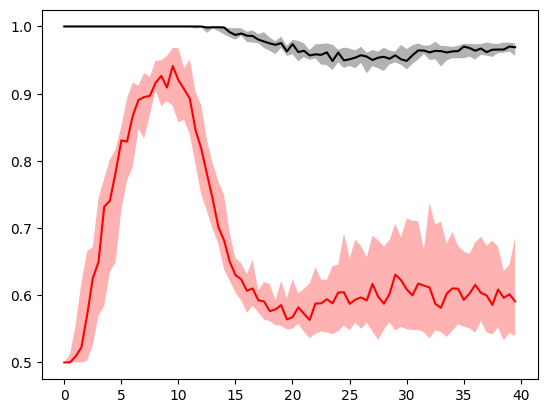

In [4]:
plt.plot(np.arange(-9.99,30,.5)+10, np.median(np.array(res_size),axis=0), color='r')
plt.fill_between(np.arange(-9.99,30,.5)+10, np.quantile(np.array(res_size), [0.25], axis=0)[0], np.quantile(np.array(res_size), [0.75], axis=0)[0], facecolor='r', alpha=.3)

plt.plot(np.arange(-9.99,30,.5)+10, np.median(np.array(res_size_dn),axis=0), color='k')
plt.fill_between(np.arange(-9.99,30,.5)+10, np.quantile(np.array(res_size_dn), [0.25], axis=0)[0], np.quantile(np.array(res_size_dn), [0.75], axis=0)[0], facecolor='k', alpha=.3)


In [1]:
import pickle

with open('res.pickle','rb') as f:
    (res_delta, res_delta_dn, res_eps, res_eps_dn, res_size, res_size_dn) = pickle.load(f)

In [60]:
def moving_avg(arr, win=5):
    res = []
    l = 0
    r = 0 
    length = len(arr)
    while r<length:
        res.append(np.mean(arr[l:r+1]))

        if r>=win-1:
            l += 1

        r += 1
    return res
    
    

In [61]:
moving_avg([1,2,3,4,5,6,7])

[1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]

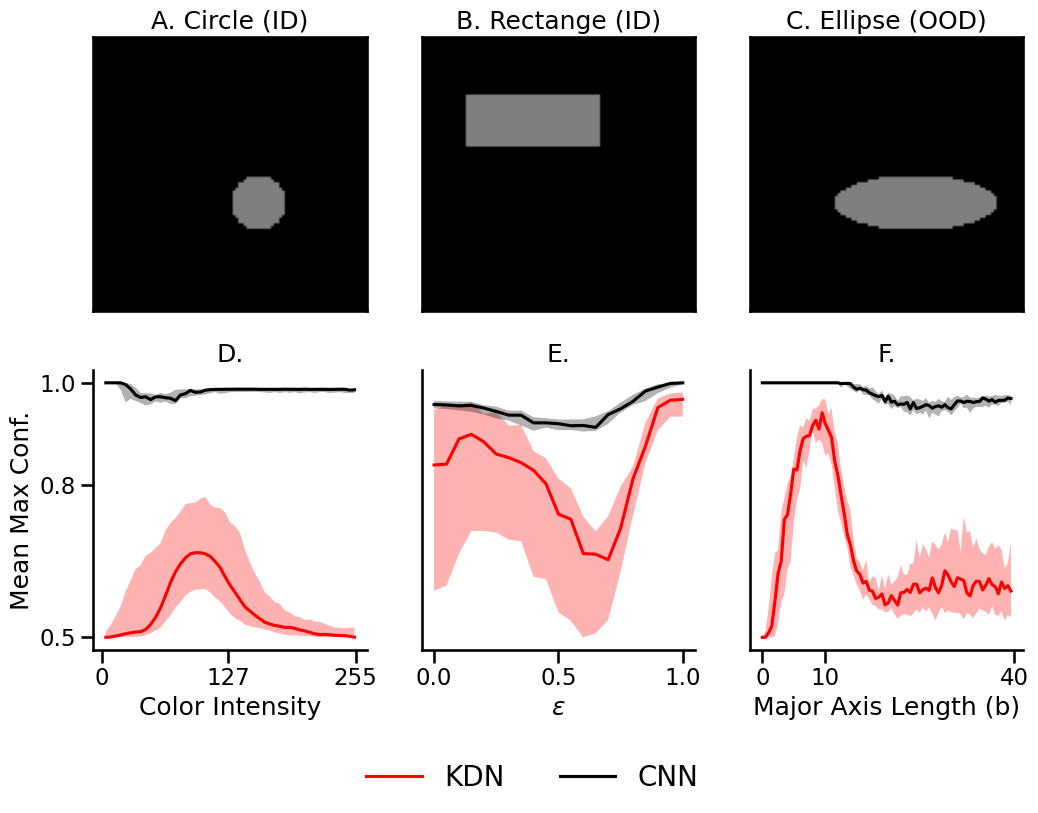

In [66]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
sns.set_context('talk')

img = sim_circle([60,60], r=10, rgb=[127,127,127])
img_rect = sim_rectangle([30,40], w=50, h=20, rgb=[127,127,127])
img_ell = sim_ellipse([60,60], a=10, b=30, rgb=[127,127,127])

ax[0][0].imshow(img)
ax[0][0].set_title('A. Circle (ID)')

ax[0][1].imshow(img_rect)
ax[0][1].set_title('B. Rectange (ID)')

ax[0][2].imshow(img_ell)
ax[0][2].set_title('C. Ellipse (OOD)')

for ii in range(3):
    ax[0][ii].set_xticks([])
    ax[0][ii].set_yticks([])

ax[1][0].plot(np.array(range(127,-127,-5))+127, moving_avg(np.median(np.array(res_delta),axis=0)), color='r', label='KDN')
ax[1][0].fill_between(np.array(range(127,-127,-5))+127,moving_avg( np.quantile(np.array(res_delta), [0.25], axis=0)[0]), moving_avg(np.quantile(np.array(res_delta), [0.75], axis=0)[0]), facecolor='r', alpha=.3)


ax[1][0].plot(np.array(range(127,-127,-5))+127, np.median(np.array(res_delta_dn),axis=0), color='k', label='CNN')
ax[1][0].fill_between(np.array(range(127,-127,-5))+127, np.quantile(np.array(res_delta_dn), [0.25], axis=0)[0], np.quantile(np.array(res_delta_dn), [0.75], axis=0)[0], facecolor='k', alpha=.3)

ax[1][0].set_title('D.')
ax[1][0].set_xlabel('Color Intensity')
ax[1][0].set_ylabel('Mean Max Conf.')
ax[1][0].set_yticks([0.5, 0.8, 1])
ax[1][0].set_xticks([0, 127, 255])


ax[1][1].plot(np.arange(0,1.05,.05), np.median(np.array(res_eps),axis=0), color='r')
ax[1][1].fill_between(np.arange(0,1.05,.05), np.quantile(np.array(res_eps), [0.25], axis=0)[0], np.quantile(np.array(res_eps), [0.75], axis=0)[0], facecolor='r', alpha=.3)

ax[1][1].plot(np.arange(0,1.05,.05), np.median(np.array(res_eps_dn),axis=0), color='k')
ax[1][1].fill_between(np.arange(0,1.05,.05), np.quantile(np.array(res_eps_dn), [0.25], axis=0)[0], np.quantile(np.array(res_eps_dn), [0.75], axis=0)[0], facecolor='k', alpha=.3)

ax[1][1].set_title('E.')
ax[1][1].set_xlabel(r'$\epsilon$')
ax[1][1].set_yticks([])

ax[1][2].plot(np.arange(-9.99,30,.5)+10, np.median(np.array(res_size),axis=0), color='r')
ax[1][2].fill_between(np.arange(-9.99,30,.5)+10, np.quantile(np.array(res_size), [0.25], axis=0)[0], np.quantile(np.array(res_size), [0.75], axis=0)[0], facecolor='r', alpha=.3)

ax[1][2].plot(np.arange(-9.99,30,.5)+10, np.median(np.array(res_size_dn),axis=0), color='k')
ax[1][2].fill_between(np.arange(-9.99,30,.5)+10, np.quantile(np.array(res_size_dn), [0.25], axis=0)[0], np.quantile(np.array(res_size_dn), [0.75], axis=0)[0], facecolor='k', alpha=.3)

ax[1][2].set_title('F.')
ax[1][2].set_xlabel('Major Axis Length (b)')
ax[1][2].set_yticks([])
ax[1][2].set_xticks([0, 10, 40])

leg = ax[1][0].legend(bbox_to_anchor=(0.65, -0.001), bbox_transform=plt.gcf().transFigure,
                        ncol=2, fontsize=20, frameon=False)

for ii in range(3):
    right_side = ax[1][ii].spines["right"]
    right_side.set_visible(False)
    top_side = ax[1][ii].spines["top"]
    top_side.set_visible(False)

plt.savefig('image_simulation.pdf', bbox_inches='tight')